### 2024.11.13 - Policy Objective Function
Proximal Policy Optimization (PPO) is a policy gradient method for reinforcement learning used in the final training stage of GPT. In this homework, you will look at the clipped surrogate objective function:

$L^{PG}(\theta) = E_t[\log \pi_\theta(a_t|s_t) * A_t]$

We know there is quite a long path between this exercise and the complete application of PPO in RLHF. However, since this is an introductory lecture and due to the vast diversity of the audience, we will not go into more depth.
In case you are interested in diving deeper into the realm of reinforcement learning and PPO, check the following resources:
- [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html)
- [Lilian Weng Policy Gradient Algorithms](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/)
- [Proximal Policy Optimization (PPO): The Key to LLM Alignment](https://cameronrwolfe.substack.com/p/proximal-policy-optimization-ppo)

Base your code on the following skeleton code that we provide.

#### The context of this exercise
In RLHF, the first step is that a pre-trained model generates multiple responses for individual prompts. In the second stage humans annotate those prompts with their preferences (this can be ordering them, answering yes/no questions like is this harmful or rating individual completions on numerical scales). Using these preferences, a separate reward model is trained, whose purpose is to predict human preferences and critique or judge future outputs of the language model.

In the final stage, the objective function $L^{PG}(\theta)$ is used in the final stage where the language model weights are updated to align with human preferences. It ensures that the model maximizes the reward predicted by the reward model (through advantages). Ratio clipping ensures that there are no overly extreme updates in individual steps.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def ppo_loss_components(old_probs, new_probs, advantages, epsilon=0.2):
    """Calculate the components of PPO's clipped surrogate objective function.
    
    This function implements the core PPO clipping mechanism that prevents excessive
    policy updates. It returns both the final loss and intermediate values for analysis.
    
    Args:
        old_probs (torch.Tensor): Probabilities from the old policy
        new_probs (torch.Tensor): Probabilities from the new policy
        advantages (torch.Tensor): Advantage estimates
        epsilon (float, optional): Clipping parameter. Defaults to 0.2
        
    Returns:
        dict: Dictionary containing:
            - 'ratio': Probability ratios (π_new / π_old)
            - 'clipped_ratio': Ratios clipped to [1-ε, 1+ε]
            - 'surr1': First surrogate term (ratio * advantage)
            - 'surr2': Second surrogate term (clipped_ratio * advantage)
            - 'loss': Final PPO loss (negative because we want to maximize)
            
    Example Usage:
        >>> old_p = torch.tensor([0.5, 0.8])
        >>> new_p = torch.tensor([0.75, 0.3])
        >>> adv = torch.tensor([0.75])
        >>> result = ppo_loss_components(old_p, new_p, adv)
        >>> print(f"Loss: {result['loss']:.3f}")
    """
    # TODO: Implement the following steps:
    # 1. Calculate probability ratio (π_new / π_old)
    # 2. Clip the ratio to stay within [1-ε, 1+ε]
    # 3. Calculate both surrogate terms (see doc string)
    # 4. Take minimum of the surrogates and from that the mean for final loss.
    # 
    # 5. (already implemented) Return all components in a dictionary

    # Hints:
    # - Should be doable in 5 lines of code | don't overcomplicate it
    # - You might use torch.clamp(input, min, max) for clipping
    # - Remember to make the loss negative since we want to maximize the objective
        
    # YOUR CODE HERE
    # 1. Calculate probability ratio
    ratio = new_probs / old_probs
    
    # 2. Clip the ratio to stay within [1-ε, 1+ε]
    clipped_ratio = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
    
    # 3. Calculate surrogate terms
    surr1 = ratio * advantages
    surr2 = clipped_ratio * advantages
    
    # 4. Take the minimum of the surrogates and compute the mean for the final loss (*-1 because loss is negative number)
    loss = -torch.mean(torch.min(surr1, surr2))

    return {
        'ratio': ratio,
        'clipped_ratio': clipped_ratio,
        'surr1': surr1,
        'surr2': surr2,
        'loss': loss
    }

#### What should you see here?
The graphs illustrate the key mechanics of PPO's clipping mechanism with positive advantages.
The top graph shows how PPO clips the probability ratio ($\pi_{new}/\pi_{old}$) to stay within [0.8, 1.2] (with $\epsilon$=0.2). The blue line shows the unclipped ratio, while the red line shows how clipping constrains it.
The bottom graph shows three components:

- Blue line (Surrogate 1): The unclipped objective (ratio * advantage)
- Red line (Surrogate 2): The clipped objective
- Green line (Final objective): The minimum of the two surrogates

You should see that clipping prevents excessive policy updates by flattening the objective when the ratio moves too far from 1.0. This creates a pessimistic bound on the improvement and helps maintain stable training by avoiding large policy changes.
For example, at a ratio of 1.5, the original objective would continue growing linearly, but clipping ensures the actual update remains moderate.
The asymmetry of clipping ensures that if an action produces a good result, we don't need to make it dramatically more likely— a moderate increase is sufficient. However, if an action produces an undesired result (negative advantage), we want to allow stronger updates to reduce its probability.

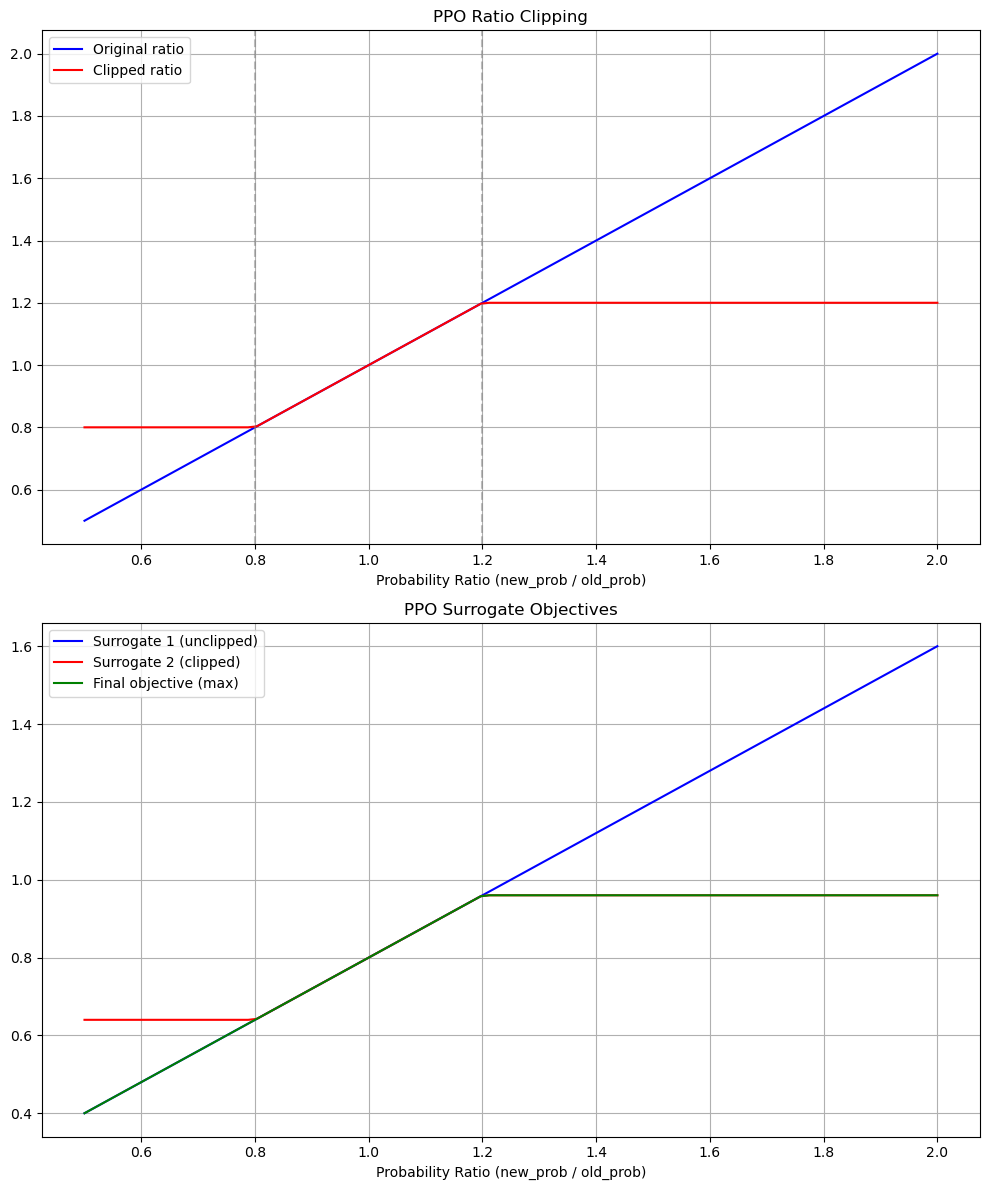


Example values for probability ratio = 1.5:
Original ratio: 1.500
Clipped ratio: 1.200
Surrogate 1: 1.200
Surrogate 2: 0.960
Final objective: 0.960


In [3]:
# Test scenario 1: Fixed old_prob with varying new_prob
old_prob = torch.tensor([1.0])
new_probs = torch.tensor(np.linspace(0.5, 2.0, 100)).float()
advantages = torch.tensor([.8])  # Positive advantage

# Calculate components across range of probability ratios
results = []
for new_p in new_probs:
    components = ppo_loss_components(old_prob, new_p.reshape(1), advantages)
    results.append({
        'ratio': components['ratio'].item(),
        'clipped_ratio': components['clipped_ratio'].item(),
        'surr1': components['surr1'].item(),
        'surr2': components['surr2'].item(),
        'loss': components['loss'].item()
    })

# Extract results for plotting
ratios = [r['ratio'] for r in results]
clipped = [r['clipped_ratio'] for r in results]
surr1 = [r['surr1'] for r in results]
surr2 = [r['surr2'] for r in results]
losses = [-r['loss'] for r in results]  # Negative since we maximize

# Create plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot 1: Ratio Clipping
ax1.plot(ratios, ratios, label='Original ratio', color='blue')
ax1.plot(ratios, clipped, label='Clipped ratio', color='red')
ax1.axvline(x=0.8, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=1.2, color='gray', linestyle='--', alpha=0.5)
ax1.grid(True)
ax1.set_title('PPO Ratio Clipping')
ax1.set_xlabel('Probability Ratio (new_prob / old_prob)')
ax1.legend()

# Plot 2: Surrogate Objectives and Loss
ax2.plot(ratios, surr1, label='Surrogate 1 (unclipped)', color='blue')
ax2.plot(ratios, surr2, label='Surrogate 2 (clipped)', color='red')
ax2.plot(ratios, losses, label='Final objective (max)', color='green')
ax2.grid(True)
ax2.set_title('PPO Surrogate Objectives')
ax2.set_xlabel('Probability Ratio (new_prob / old_prob)')
ax2.legend()

plt.tight_layout()
plt.show()

# Print some example values
print("\nExample values for probability ratio = 1.5:")
idx = np.abs(np.array(ratios) - 1.5).argmin()
print(f"Original ratio: {ratios[idx]:.3f}")
print(f"Clipped ratio: {clipped[idx]:.3f}")
print(f"Surrogate 1: {surr1[idx]:.3f}")
print(f"Surrogate 2: {surr2[idx]:.3f}")
print(f"Final objective: {losses[idx]:.3f}")

In [4]:
# Test 1: Basic ratio clipping
old_probs = torch.tensor([1.0])
new_probs = torch.tensor([1.5])
advantages = torch.tensor([1.2])

components = ppo_loss_components(old_probs, new_probs, advantages)
assert abs(components['clipped_ratio'].item() - 1.2) < 1e-5  # Should clip at 1.2 allow for small numerical error
assert components['surr1'].item() > components['surr2'].item() # Unclipped > clipped for ratio > 1
assert components['loss'].item() < 0 # Loss should be negative since we maximize
assert abs(components['loss'].item()) < components['surr1'].item() # Abs loss should be smaller than unclipped surrogate
assert abs(components['loss'].item()) == components['surr2'].item() # Loss should be negative since we maximize

# Test 2: Negative advantages
advantages = torch.tensor([-1.0])
components = ppo_loss_components(old_probs, new_probs, advantages)
assert components['surr1'].item() < components['surr2'].item()  # Min should pick surr1

# Test 3: Within clipping range
new_probs = torch.tensor([1.1])
advantages = torch.tensor([1.0])
components = ppo_loss_components(old_probs, new_probs, advantages)
assert torch.allclose(components['ratio'], components['clipped_ratio'])

# Test 4: Batch processing
old_probs = torch.tensor([1.0, 1.0, 1.0])
new_probs = torch.tensor([0.5, 1.0, 2.0])
advantages = torch.tensor([1.0, 1.0, 1.0])
components = ppo_loss_components(old_probs, new_probs, advantages)
assert len(components['ratio']) == 3

print("All tests passed! ✅")

All tests passed! ✅
